In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [2]:
import torch

from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import *
from utils import *
from interp_utils import *
from probing import *
from sparse_coding import *

### Load Model

Loading contents from file...


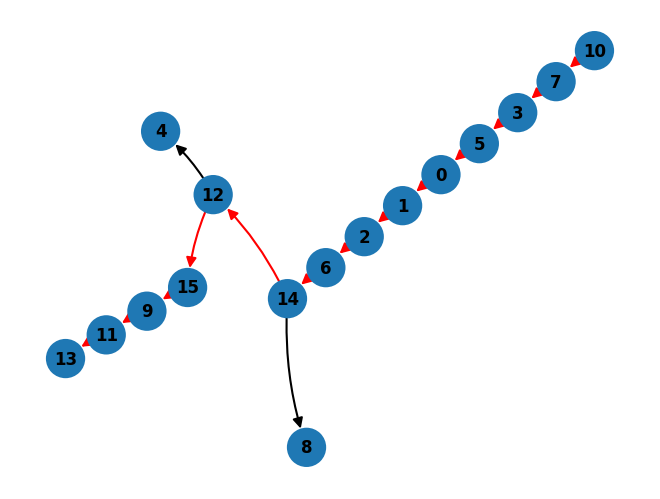

In [3]:
n_examples = 300_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)

In [4]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


# Load in the model if weights are in the directory, else train new model
if os.path.exists("model.pt"):
    model.load_state_dict(torch.load("model.pt"))

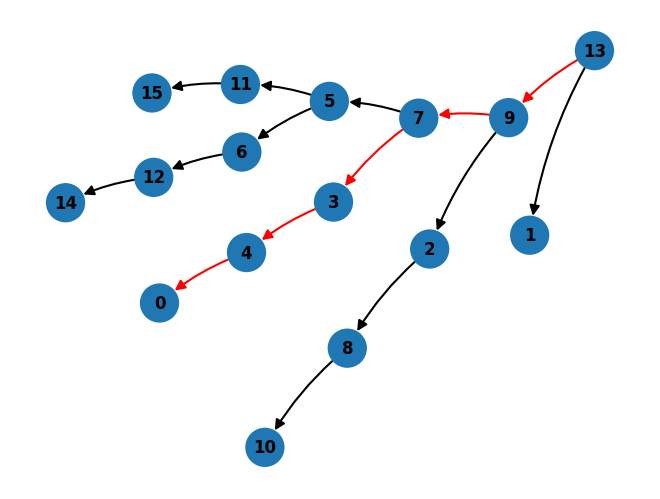

In [5]:
import random

pred = generate_example(16, 0, order="backward", path_length=5)
if is_model_correct(model, dataset, pred):
    parse_example(pred)
cache = get_example_cache(pred, model, dataset)

### Compare Subpaths to Full Path

In [6]:
def delete_non_paths(input_dict):
    keys_to_delete = [key for key, value in input_dict.items() if len(value) <= 2]
    for key in keys_to_delete:
        del input_dict[key]
    return input_dict

special_chars = [",", ":", "|"]
def get_paths(cache, labels, threshold=0.6):

    paths = {}
    for layer in range(1, 6):
        attn_pattern = cache[f"blocks.{layer}.attn.hook_pattern"]
        _, _, seq_len, _ = attn_pattern.shape

        for current_pos in range(seq_len):       
            current_token = labels[current_pos]     
            for attended_pos in range(seq_len):
                attn_value = attn_pattern[0, 0, current_pos, attended_pos]
                if attn_value > threshold:
                    attended_token = labels[attended_pos].replace(">", "")
                    previous_token = labels[attended_pos - 1].replace(">", "")
                    if not attended_token in special_chars and not previous_token in special_chars:
                        identifier = (current_pos, current_token)
                        if identifier in paths.keys():
                            paths[identifier].append(previous_token)
                        else:
                            paths[identifier] = [attended_token, previous_token]
    
    paths = delete_non_paths(paths)
    return paths

In [7]:
def can_construct_full_path(subpaths, full_path):
    # create a set of edges from the subpaths
    edges = set()
    for subpath in subpaths:
        for i in range(len(subpath) - 1):
            edges.add((subpath[i], subpath[i+1]))

    # create a set of edges required to traverse the full path
    required_edges = set()
    for i in range(len(full_path) - 1):
        required_edges.add((full_path[i], full_path[i+1]))

    # check if all required edges are in the set of edges from the subpaths
    return required_edges.issubset(edges)

{(36, '9'): ['6', '5', '7', '9'],
 (38, ','): ['10', '8', '2', '9'],
 (39, '13'): ['3', '7', '9'],
 (41, ','): ['2', '9', '13'],
 (42, '13'): ['11', '5', '7', '9'],
 (44, '|'): ['5', '7', '9', '13'],
 (45, '0'): ['4', '3', '7'],
 (47, '13'): ['0', '4', '3', '7'],
 (48, '>9'): ['0', '4', '3'],
 (49, '>7'): ['0', '4', '3'],
 (50, '>3'): ['0', '4', '3', '7'],
 (51, '>4'): ['0', '4', '3', '3'],
 (52, '>0'): ['0', '4', '4'],
 (46, ':'): ['7', '9', '13'],
 (2, ','): ['14', '12', '12']}

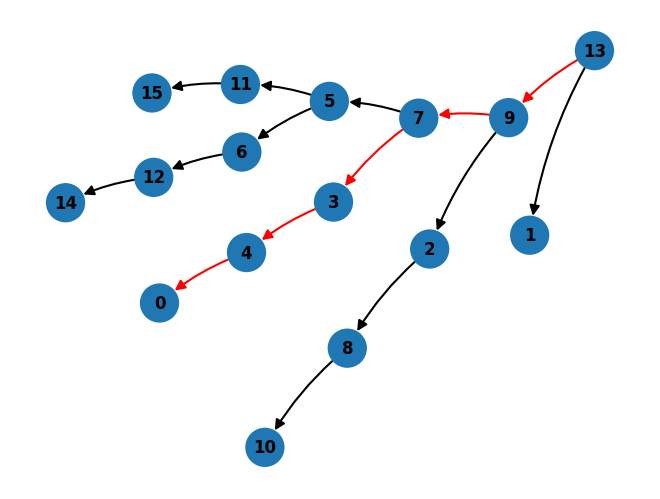

In [9]:
"7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1,14>15,13>14,12>13,11>12,10>11,9>10,0>9|8:0>1>2>3>4>5>6>7>8"
if is_model_correct(model, dataset, pred):
    parse_example(pred)
labels, cache = get_example_cache(pred, model, dataset)

subpaths = get_paths(cache, labels)
subpaths

In [55]:
import random

def remove_duplicates(list_of_lists):
    unique_data = set(map(tuple, list_of_lists))
    return list(map(list, unique_data))

n_examples = 200
outputs = {}
for _ in range(n_examples):

    # get example
    random_seed = np.random.randint(1_000_000, 1_000_000_000)
    graph = generate_example(n_states, random_seed, order="backward")
    full_path = graph.split(":")[1].split(">")[1:]  # we ignore the first position, might need to reconsider this at some point

    # get cache
    prediction, is_correct = eval_model(model, dataset, graph)
    labels, cache = get_example_cache(prediction, model, dataset)

    # get subpaths and reverse (as the model is backtracking)
    subpaths = get_paths(cache, labels)
    reversed_subpaths = [subpath[::-1] for subpath in list(subpaths.values())]
    reversed_subpaths = remove_duplicates(reversed_subpaths)
    
    # check if full path can be constructed from subpaths
    full_path_in_subpaths = can_construct_full_path(reversed_subpaths, full_path)
    outputs[random_seed] = {
        "graph": graph,
        "prediction": prediction,
        "is_correct": is_correct,
        "full_path_in_subpaths": full_path_in_subpaths,
        "full_path": "full_path",
        "reversed_subpaths": reversed_subpaths,
    }

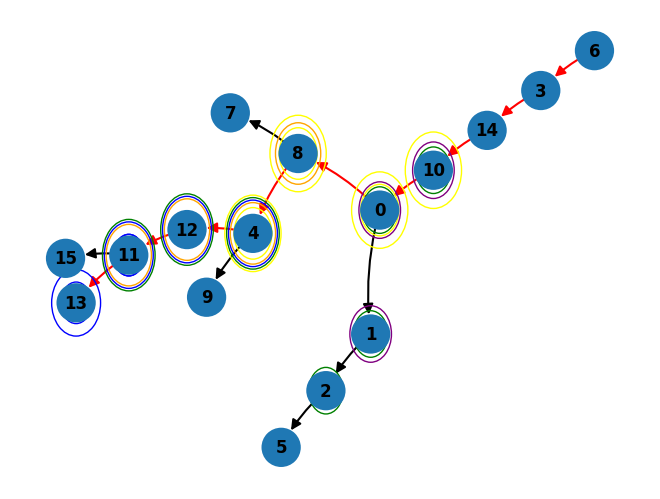

In [75]:
import networkx as nx
import matplotlib.pyplot as plt
import math
from tree_generation import hierarchy_pos

def parse_example(example_str: str, reversed_subpaths: list = []):
    # ... [existing code]

    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    node_edge_sizes = [0 for i in range(len(nodes))]
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    pos = hierarchy_pos(G)
    new_pos = {u:(r*math.cos(theta),r*math.sin(theta)) for u, (theta, r) in pos.items()}
    nx.draw(
        G,
        pos=new_pos,
        font_weight="bold",
        connectionstyle='arc3, rad = 0.1',
        with_labels=True,
        edgecolors="darkgoldenrod",
        linewidths=node_edge_sizes,
        arrowsize=15,
        width=1.5,
        node_size=800,
        edge_color=[G[u][v]['color'] for u, v in G.edges()]
    )

    # Now, draw the circles for reversed_subpaths
    radius_increment = 0.006  # Increment radius for each subpath
    base_radius = 0.05       # Starting radius for the circles
    colors = ['blue', 'green', 'yellow', 'purple', 'orange']  # Add more colors if needed

    for i, subpath in enumerate(reversed_subpaths):
        for node in subpath:
            node_pos = new_pos[int(node)]
            circle = plt.Circle(node_pos, base_radius + i * radius_increment, color=colors[i % len(colors)], fill=False)
            plt.gca().add_artist(circle)

    plt.show()

example = outputs[226714103]
parse_example(example["graph"], example["reversed_subpaths"])


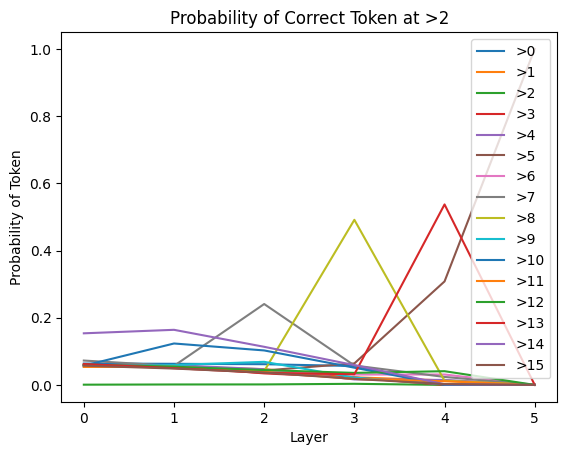

In [73]:
import torch
import os

def load_lenses(directory="lenses"):
    lenses = {}
    for filename in os.listdir(directory):
        if filename.endswith(".pt"):
            key = filename[:-3]  # Remove the ".pt" extension
            filepath = os.path.join(directory, filename)
            lenses[key] = torch.load(filepath)
    return lenses

lenses= load_lenses()

def logit_lens_all_probs(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, cache = get_example_cache(pred, model, dataset)
    current_node = int(labels[position].split(">")[-1])
    current_neighbors = [f">{i}" for i in range(dataset.n_states)]
    # Get the logit lens for each layer's resid_post
    probs = {key: [] for key in current_neighbors}
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.softmax(-1)
        for key in probs:
            key_prob = out_proj[position, dataset.tokens2idx[key]].item()
            probs[key].append(key_prob)
    # Plot data
    for key in probs:
        plt.plot(probs[key], label=key)
    plt.xlabel("Layer")
    plt.ylabel(f"Probability of Token")
    plt.title(f"Probability of Correct Token at {labels[position]}")
    plt.legend()
    plt.show()
    # Return result
    return probs

probs = logit_lens_all_probs(example["graph"], model, dataset, 48, lenses=lenses)

In [70]:
logit_lens(example["graph"], model, dataset, lenses=lenses)

In [71]:
is_not_corrects = [(k, v) for k, v in outputs.items() if v["full_path_in_subpaths"] == False]
is_not_corrects

[(421280456,
  {'graph': '10>14,10>11,7>10,8>7,13>9,13>8,0>13,12>3,12>0,1>15,5>12,5>1,2>6,2>5,4>2|14:4>2>5>12>0>13>8>7>10>14',
   'prediction': '10>14,10>11,7>10,8>7,13>9,13>8,0>13,12>3,12>0,1>15,5>12,5>1,2>6,2>5,4>2|14:4>2>5>12>0>13>8>7>10>14',
   'is_correct': True,
   'full_path_in_subpaths': False,
   'full_path': 'full_path',
   'reversed_subpaths': [['8', '7', '10', '14'],
    ['13', '8', '7'],
    ['13', '8', '7', '10'],
    ['4', '2', '5', '1'],
    ['7', '10', '14'],
    ['2', '5', '12']]}),
 (586342323,
  {'graph': '3>15,12>14,12>3,4>12,1>10,5>4,5>1,8>5,13>8,0>9,0>6,7>13,7>0,11>7,2>11|15:2>11>7>13>8>5>4>12>3>15',
   'prediction': '3>15,12>14,12>3,4>12,1>10,5>4,5>1,8>5,13>8,0>9,0>6,7>13,7>0,11>7,2>11|15:2>11>7>13>8>5>4>12>3>15',
   'is_correct': True,
   'full_path_in_subpaths': False,
   'full_path': 'full_path',
   'reversed_subpaths': [['12', '3', '15'],
    ['13', '8', '5', '4'],
    ['13', '8', '5', '1'],
    ['8', '5', '1', '10'],
    ['4', '12', '3', '15'],
    ['5', '4

In [56]:
is_corrects = [v["is_correct"] for k, v in outputs.items()]
print(f"is_corrects: {sum(is_corrects) / len(is_corrects)}")

full_path_in_subpathss = [v["full_path_in_subpaths"] for k, v in outputs.items()]
print(f"full_path_in_subpathss: {sum(full_path_in_subpathss) / len(full_path_in_subpathss)}")

is_corrects: 0.985
full_path_in_subpathss: 0.69


### Subpath Probing

### Attention Head Visualization

In [6]:
import re

def replace_numbers_with_characters(strings_list):
    result = []
    for string in strings_list:
        # Find all numbers in the string
        numbers = re.findall(r'\d+', string)
        if numbers:
            # Assume there is exactly one number in the string
            number = int(numbers[0])
            # Check if the number is within the range 0-25
            if 0 <= number <= 25:
                # Convert the number to the corresponding alphabet character
                char = chr(ord('A') + number)
                # Replace the number with the character
                new_string = string.replace(numbers[0], char)
                # Add a space in front of each character
                spaced_string = ' '.join(new_string)
                result.append(spaced_string)
            else:
                print(f"The number {number} in string '{string}' is out of range (0-25).")
                # Add a space in front of each character
                spaced_string = ' '.join(string)
                result.append(spaced_string)
        else:
            # Add a space in front of each character
            spaced_string = ' '.join(string)
            result.append(spaced_string)
    return result

def display_head(cache, labels, layer, head, show=False):
    average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
    last_idx = average_patterns.shape[-1] - 1
    while labels[last_idx] == ",":
        last_idx -= 1
    last_idx += 1
    path_start_pos = labels.index(":") + 1
    edge_list_end_post = labels.index("|")

    matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
    labels = [l.replace(">", "\u2192") for l in labels]
    labels = replace_numbers_with_characters(labels)
    
    labels_y = labels[path_start_pos:last_idx]
    labels_x = labels[:edge_list_end_post]
    fig = px.imshow(
        matrix,
        labels=dict(x="Previous Token attended to", y="Correct Next Step", color="Value"),
        color_continuous_scale="Blues",
        zmin=0,
        zmax=1,
        aspect="auto"
    )
    
    layout = dict(
        width=1200,
        height=400,
        xaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_x,
        ),
        yaxis=dict(
            tickmode="array",
            tickvals=np.arange(len(labels)),
            ticktext=labels_y,
        )
    )
    fig.update_layout(layout)
    if show:
        fig.show()
    else:
        return fig
    
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=False)
        fig.write_image(f'./images/attn_{l}_{h}.png')

In [ ]:
average_patterns = cache[f"blocks.{layer}.attn.hook_pattern"]
        last_idx = average_patterns.shape[-1] - 1
        while labels[last_idx] == ",":
            last_idx -= 1
        last_idx += 1
        path_start_pos = labels.index(":") + 1
        edge_list_end_post = labels.index("|")

        matrix = average_patterns[0, head, path_start_pos:last_idx, :edge_list_end_post].cpu()
        labels = [l.replace(">", "\u2192") for l in labels]
        labels = replace_numbers_with_characters(labels)
        
        labels_y = labels[path_start_pos:last_idx]
        labels_x = labels[:edge_list_end_post]
        

In [36]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache[1], cache[0], l, h, show=True)

In [9]:
cache[1].keys()

dict_keys(['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_pre', 'block

### Probing Dataset

In [10]:
#act_names = ["ln_final.hook_normalized"]
#act_names += [f"blocks.{i}.ln2.hook_normalized" for i in range(model.cfg.n_layers)]
act_names = [f"blocks.3.hook_resid_post"]
#act_names += [f"blocks.{i}.mlp.hook_post" for i in range(model.cfg.n_layers)]
import random
model.reset_hooks()

def aggregate_activations(model, dataset, activation_keys, n_samples, order, path_length=None):
    act_cache = {ak: [] for ak in activation_keys}
    graphs = []
    for _ in range(n_samples):
        example_graph = generate_example(
            n_states=dataset.n_states,
            seed=random.randint(300_000, 1_000_000_000),
            path_length=path_length,
            order=order
        )
        correct = is_model_correct(model, dataset, example_graph)
        if not correct:
            continue
        _, cache = get_example_cache(example_graph, model, dataset)
        graphs.append(example_graph)
        for key in activation_keys:
            act_cache[key].append(cache[key].cpu())
    return act_cache, graphs

activations_file = "activations_3_hook_resid_post_4k.pt"
if not os.path.exists(activations_file):
    print("Generating activations ...")
    
    acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=4_000,
        order="backward"
    )

    test_acts, test_graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=1_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, test_acts, test_graphs) , activations_file)
else:
    print("loading activations ... ")
    acts, graphs, test_acts, test_graphs = torch.load(activations_file)


Generating activations ...


In [8]:
def extract_transposed_adj_matrix(example_str, power=1):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            color = "red"
        else:
            color = "black"
        G.add_edge(edge[0], edge[1], color=color)
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray().T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

In [29]:
def extract_transposed_adj_matrix_only_path(example_str, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node = int(e.split(">")[0])
        in_node = int(e.split(">")[1])
        edgelist.append((out_node, in_node))
        nodes.add(out_node)
        nodes.add(in_node)
    # Extract path
    goal = example_str.split("|")[1]
    goal_node = int(goal.split(":")[0])
    path = goal.split(":")[1].split(">")
    path = [int(p) for p in path]
    path_edges = list(zip(path[:-1], path[1:]))
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(range(len(nodes)))
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(edge[0], edge[1])
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency

In [10]:
import numpy as np
import networkx as nx

def extract_transposed_adj_matrix_only_path(example_str, N, power=1, transposed=False):
    # Extract edgelist
    graph = example_str.split("|")[0]
    graph = graph.split(",")
    edgelist = []
    nodes = set()
    for e in graph:
        out_node, in_node = map(int, e.split(">"))
        edgelist.append((out_node, in_node))
        nodes.update([out_node, in_node])
    
    # Extract path
    goal = example_str.split("|")[1]
    goal_node, path_str = goal.split(":")
    goal_node = int(goal_node)
    path = list(map(int, path_str.split(">")))
    
    # Only include the last N edges from the goal in the path
    if N > 0:
        path = path[-(N+1):]
    
    path_edges = list(zip(path[:-1], path[1:]))
    
    # Make sure every edge in the path is valid
    for edge in path_edges:
        assert edge in edgelist, f"Edge {edge} not in edgelist"
    
    # Create networkx graph
    G = nx.DiGraph()
    G.add_nodes_from(nodes)
    for edge in edgelist:
        if edge in path_edges:
            G.add_edge(*edge)
    
    # Convert to numpy adjacency matrix
    adjacency_matrix_sparse = nx.adjacency_matrix(G)
    adjacency = adjacency_matrix_sparse.toarray()
    if transposed:
        adjacency = adjacency.T
    if power is not None:
        ## Change all leaf nodes to self-loops
        row_sums = np.sum(adjacency, axis=1)
        for i in range(len(row_sums)):
            if row_sums[i] == 0:
                adjacency[i, i] = 1
        # Exponentiate matrix
        return np.linalg.matrix_power(adjacency, power)
    else:
        return adjacency


In [11]:
acts.keys()

dict_keys(['blocks.0.hook_resid_post', 'blocks.1.hook_resid_post', 'blocks.2.hook_resid_post', 'blocks.3.hook_resid_post', 'blocks.4.hook_resid_post', 'blocks.5.hook_resid_post'])

In [30]:
def return_probing_dataset(acts, graphs):
    X = {key: [] for key in acts.keys()}
    y = []
    for gidx, graph in enumerate(graphs):
        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1
        # get adjacency matrix of only path
        y.append(extract_transposed_adj_matrix_only_path(graph, None).flatten())
        # Iterate over all layers residual streams
        for key in X.keys():
            # streams = acts[key][gidx][0, start_idx-1:start_idx]  # only pos 47
            streams = acts[key][gidx][0, start_idx-1:start_idx]
            X[key].append(streams)
    # Convert everything to np arrays
    for key in X.keys():
        X[key] = torch.cat(X[key], dim=0).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs)

In [31]:
from sklearn.model_selection import train_test_split

len(dataX["blocks.4.hook_resid_post"])
dataX, dataXTest, y, y_test = train_test_split(dataX["blocks.4.hook_resid_post"], y, test_size=0.2, random_state=42)


len(dataX)
len(dataXTest)

12587

### Nonlinear Probing

In [32]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

import warnings
warnings.filterwarnings("ignore")


probe = probing.NonlinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Epoch 1 - Training Loss: 7.6165 - Val. Acc.: 0.97 - Val. Prec.: 0.41 - Val. Rec.: 0.00 
Epoch 20 - Training Loss: 3.2214 - Val. Acc.: 0.97 - Val. Prec.: 0.68 - Val. Rec.: 0.24 
Epoch 40 - Training Loss: 2.3424 - Val. Acc.: 0.97 - Val. Prec.: 0.63 - Val. Rec.: 0.34 
Epoch 60 - Training Loss: 1.9009 - Val. Acc.: 0.97 - Val. Prec.: 0.56 - Val. Rec.: 0.38 
Epoch 80 - Training Loss: 1.6077 - Val. Acc.: 0.97 - Val. Prec.: 0.52 - Val. Rec.: 0.40 
Epoch 100 - Training Loss: 1.3978 - Val. Acc.: 0.96 - Val. Prec.: 0.50 - Val. Rec.: 0.41 
Epoch 120 - Training Loss: 1.2321 - Val. Acc.: 0.96 - Val. Prec.: 0.48 - Val. Rec.: 0.41 
Epoch 140 - Training Loss: 1.1045 - Val. Acc.: 0.96 - Val. Prec.: 0.47 - Val. Rec.: 0.42 
Epoch 160 - Training Loss: 0.9920 - Val. Acc.: 0.96 - Val. Prec.: 0.46 - Val. Rec.: 0.42 
Epoch 180 - Training Loss: 0.9019 - Val. Acc.: 0.96 - Val. Prec.: 0.45 - Val. Rec.: 0.42 
Epoch 200 - Training Loss: 0.8209 - Val. Acc.: 0.96 - Val. Prec.: 0.44 - Val. Rec.: 0.42 
Epoch 220 - Trai

In [42]:
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Accuracy: 99.32%
Precision: 72.23%
Recall: 61.03%


In [11]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

for label in acts.keys():
    print(label)

    X = dataX[label]
    X_test = dataXTest[label]

    probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
    probe.fit(X, y.astype(np.float32))
    print(probe.score(X, y))

    answers = (probe.predict(X_test) > 0.5)
    y_pred = answers.flatten()
    y_true = y_test.flatten()

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)

    print('Accuracy: {:.2f}%'.format(accuracy*100))
    print('Precision: {:.2f}%'.format(precision*100))
    print('Recall: {:.2f}%'.format(recall*100))

blocks.0.hook_resid_post
Epoch 50 - Training Loss: 7.2492 - Validation Accuracy: 0.97
Epoch 100 - Training Loss: 7.1879 - Validation Accuracy: 0.97
Epoch 150 - Training Loss: 7.1396 - Validation Accuracy: 0.97
Epoch 200 - Training Loss: 7.0998 - Validation Accuracy: 0.97
Epoch 250 - Training Loss: 7.0668 - Validation Accuracy: 0.97
Epoch 300 - Training Loss: 7.0441 - Validation Accuracy: 0.97
Epoch 350 - Training Loss: 7.0252 - Validation Accuracy: 0.97
Epoch 400 - Training Loss: 7.0115 - Validation Accuracy: 0.97
Epoch 450 - Training Loss: 6.9973 - Validation Accuracy: 0.97
Epoch 500 - Training Loss: 6.9857 - Validation Accuracy: 0.97
Epoch 550 - Training Loss: 6.9806 - Validation Accuracy: 0.97
Epoch 600 - Training Loss: 6.9717 - Validation Accuracy: 0.97
Epoch 650 - Training Loss: 6.9647 - Validation Accuracy: 0.97
Epoch 700 - Training Loss: 6.9625 - Validation Accuracy: 0.97
Epoch 750 - Training Loss: 6.9602 - Validation Accuracy: 0.97
Epoch 800 - Training Loss: 6.9582 - Validation

Accuracy: 99.82%
Precision: 97.41%
Recall: 96.09%


In [ ]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

### Sparse Coding + Linear Probing

In [ ]:

coder = SparseCoder(4096, max_iter=5_000, batch_size=8192, l1_coef=0.001, learning_rate_init=3e-4, verbose=True)
coder.fit(X)

In [14]:
from sparse_coding import *

d_model = dataX['blocks.4.hook_resid_post'].shape[-1]
coder = SparseCoder(num_codes=4*d_model, verbose=True)

# train
coder.fit(dataX['blocks.4.hook_resid_post'])
torch.save(coder.model.state_dict(), f'sae_resid_post_4.pt')


Epoch 0 | Sparsity: 251.3552 | Training Loss: 638.5477 | Validation Loss: 73.7403 | Reconstruction Loss: 22.3156 | Sparsity Loss: 0.4896
Epoch 20 | Sparsity: 367.5707 | Training Loss: 47.4989 | Validation Loss: 3.0672 | Reconstruction Loss: 0.7826 | Sparsity Loss: 0.9138
Epoch 40 | Sparsity: 359.4857 | Training Loss: 32.4095 | Validation Loss: 1.4652 | Reconstruction Loss: 0.3657 | Sparsity Loss: 0.7918
Epoch 60 | Sparsity: 342.2524 | Training Loss: 26.5956 | Validation Loss: 1.0792 | Reconstruction Loss: 0.2677 | Sparsity Loss: 0.6822
Epoch 80 | Sparsity: 325.5965 | Training Loss: 23.1308 | Validation Loss: 0.8816 | Reconstruction Loss: 0.2181 | Sparsity Loss: 0.6080
Epoch 100 | Sparsity: 307.2504 | Training Loss: 20.5908 | Validation Loss: 0.7515 | Reconstruction Loss: 0.1854 | Sparsity Loss: 0.5500
Epoch 120 | Sparsity: 286.4763 | Training Loss: 18.4726 | Validation Loss: 0.6527 | Reconstruction Loss: 0.1606 | Sparsity Loss: 0.4991
Epoch 140 | Sparsity: 263.5843 | Training Loss: 16.

In [13]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

probe = probing.NonlinearMultiClsProbe(max_iter=600, verbose=True)
features = coder.featurize(X.astype(np.float32))
probe.fit(features, y.astype(np.float32))
print(probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

KeyboardInterrupt: 

In [59]:
linear_probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True)
features = coder.featurize(X.astype(np.float32))
linear_probe.fit(features, y.astype(np.float32))
print(linear_probe.score(features,y.astype(np.float32)))
feats = coder.featurize(X_test)

Epoch 0 - Training Loss: 9.2325 - Validation Accuracy: 0.97
Epoch 50 - Training Loss: 3.0265 - Validation Accuracy: 0.97
Epoch 100 - Training Loss: 2.7693 - Validation Accuracy: 0.97
Epoch 150 - Training Loss: 2.6733 - Validation Accuracy: 0.97
Epoch 200 - Training Loss: 2.6351 - Validation Accuracy: 0.97
Epoch 250 - Training Loss: 2.6181 - Validation Accuracy: 0.97
Epoch 300 - Training Loss: 2.6097 - Validation Accuracy: 0.97
Epoch 350 - Training Loss: 2.6049 - Validation Accuracy: 0.97
Epoch 400 - Training Loss: 2.6020 - Validation Accuracy: 0.97
Epoch 450 - Training Loss: 2.6000 - Validation Accuracy: 0.97
Epoch 500 - Training Loss: 2.5982 - Validation Accuracy: 0.97
Epoch 550 - Training Loss: 2.5973 - Validation Accuracy: 0.97
Epoch 600 - Training Loss: 2.5967 - Validation Accuracy: 0.97
Epoch 650 - Training Loss: 2.5961 - Validation Accuracy: 0.97
Epoch 700 - Training Loss: 2.5956 - Validation Accuracy: 0.97
Epoch 750 - Training Loss: 2.5953 - Validation Accuracy: 0.97
Epoch 800 -

In [57]:
answers = (probe.predict(feats )> 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Accuracy: 99.82%
Precision: 97.48%
Recall: 96.08%


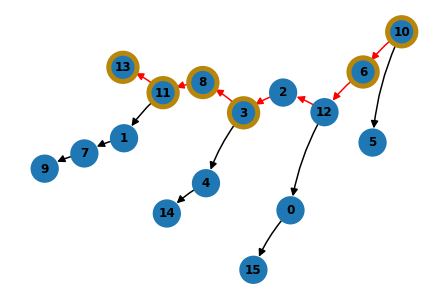

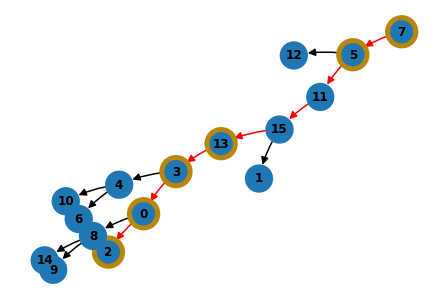

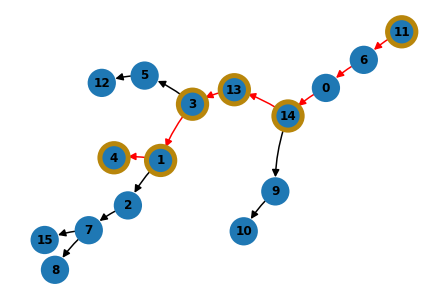

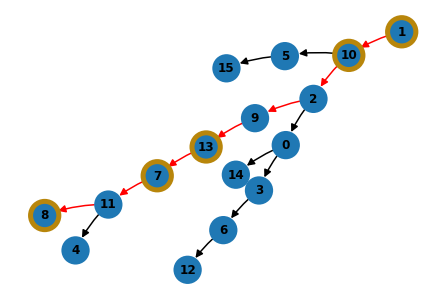

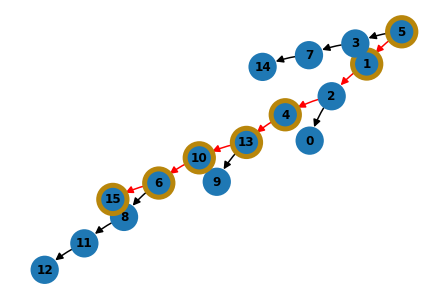

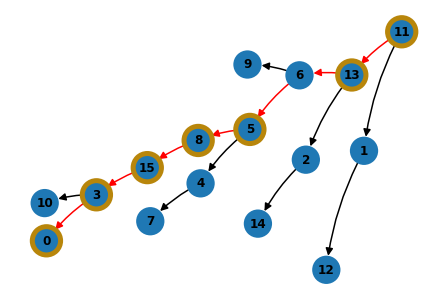

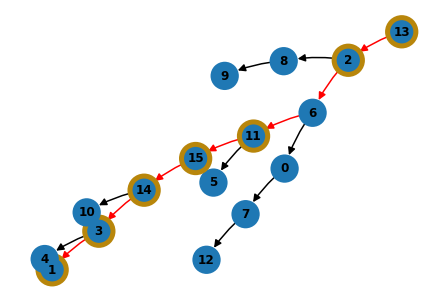

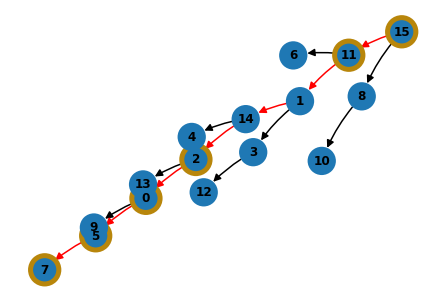

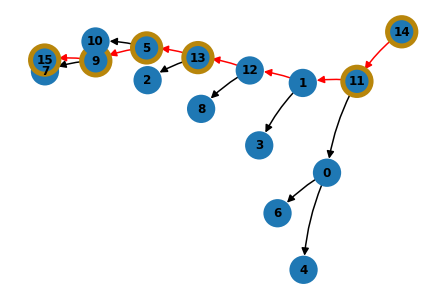

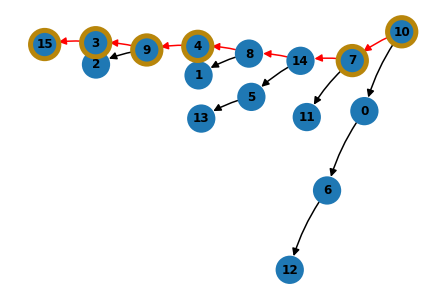

In [13]:
for test_example_idx in range(10):

    correct = np.where(y_pred[test_example_idx*16:(test_example_idx+1)*16])[0]
    parse_example(test_graphs[test_example_idx], highlight_nodes=correct.tolist())
    plt.show()

### Subpath Probing

In [6]:
#act_names = ["ln_final.hook_normalized"]
#act_names += [f"blocks.{i}.ln2.hook_normalized" for i in range(model.cfg.n_layers)]
act_names = [f"blocks.3.hook_resid_post"]
#act_names += [f"blocks.{i}.mlp.hook_post" for i in range(model.cfg.n_layers)]
import random
from tqdm import tqdm
model.reset_hooks()

def aggregate_activations_with_subpaths(model, dataset, activation_keys, n_samples, order, path_length=None):
    act_cache = {ak: [] for ak in activation_keys}
    graphs = []
    subpaths_outputs = []
    for _ in tqdm((n_samples)):
        example_graph = generate_example(
            n_states=dataset.n_states,
            seed=random.randint(300_000, 1_000_000_000),
            path_length=path_length,
            order=order
        )
        correct = is_model_correct(model, dataset, example_graph)
        if not correct:
            continue
        labels, cache = get_example_cache(example_graph, model, dataset)
        subpaths = get_paths(cache, labels)
        graphs.append(example_graph)
        subpaths_outputs.append(subpaths)
        for key in activation_keys:
            act_cache[key].append(cache[key].cpu())
    return act_cache, graphs, subpaths_outputs

activations_file = "activations_3_hook_resid_post_4k_with_subpaths.pt"
if not os.path.exists(activations_file):
    print("Generating activations ...")
    
    acts, graphs, subpaths = aggregate_activations_with_subpaths(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=4_000,
        order="backward"
    )

    test_acts, test_graphs, test_subpaths = aggregate_activations_with_subpaths(
        model=model,
        dataset=dataset,
        activation_keys=act_names,
        n_samples=1_000,
        order="backward"
    )
    
    torch.save( (acts, graphs, subpaths, test_acts, test_graphs, test_subpaths) , activations_file)
else:
    print("loading activations ... ")
    acts, graphs, subpaths, test_acts, test_graphs, test_subpaths = torch.load(activations_file)

loading activations ... 


In [19]:
import numpy as np
import networkx as nx

def extract_subpath_adj_matrix(subpath, example_str):
    # [reminder] subpath structure: ['6', '5', '7', '9']
    adj_matrix = np.zeros((16, 16))

    reversed_subpath = subpath[::-1]
    for e_idx in range(len(reversed_subpath) - 1):
        i = int(reversed_subpath[e_idx])
        j = int(reversed_subpath[e_idx + 1])
        
        # ignore self-edges
        if not i == j:

            graph = example_str.split("|")[0]
            graph = graph.split(",")
            edgelist = []
            nodes = set()
            for e in graph:
                out_node, in_node = map(int, e.split(">"))
                edgelist.append((out_node, in_node))
                nodes.update([out_node, in_node])
            nodes = list(nodes)

            # check if node in tree
            if i in nodes and j in nodes:
                # check if edge in tree
                if (i, j) in edgelist:
                    adj_matrix[i, j] = 1

    return adj_matrix

# TODO: build (and run) unit tests before running probe - look at examples and check if adj. matrix is correct
subpaths[0][(36, '7')]
extract_subpath_adj_matrix(subpaths[0][(36, '7')], graphs[0])

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,

In [23]:
def return_probing_dataset(acts, graphs, subpaths_all_graphs):
    X = []
    y = []
    for gidx, graph in enumerate(graphs):

        # Get output labels
        tokens = dataset.tokenize(graph)[:-1]
        start_idx = np.where(tokens == dataset.start_token)[0].item() + 2
        labels = [dataset.idx2tokens[idx] for idx in tokens]
        end_idx = num_last(labels, ",") + 1

        for sidx, (subpath_pos, subpath) in enumerate(subpaths_all_graphs[gidx].items()):
            # [reminder] subpath structure: (36, '9'): ['6', '5', '7', '9']

            # get X
            subpath_token_position = subpath_pos[0]
            X.append(acts["blocks.3.hook_resid_post"][gidx][0, subpath_token_position, :])
            
            # get y
            y.append(extract_subpath_adj_matrix(subpath, graph).flatten())
        
    # Convert everything to np arrays
    X = torch.stack(X).detach().cpu().numpy()
    y = np.array(y)
    return X, y


dataX, y = return_probing_dataset(acts, graphs, subpaths)
dataXTest, y_test = return_probing_dataset(test_acts, test_graphs, test_subpaths)

In [24]:
y[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [25]:
dataX.shape

(52076, 128)

In [26]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

import warnings
warnings.filterwarnings("ignore")


probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Epoch 20 - Training Loss: 0.8604 - Val. Acc.: 0.99 - Val. Prec.: 0.61 - Val. Rec.: 0.23 
Epoch 40 - Training Loss: 0.6516 - Val. Acc.: 0.99 - Val. Prec.: 0.66 - Val. Rec.: 0.39 
Epoch 60 - Training Loss: 0.5722 - Val. Acc.: 0.99 - Val. Prec.: 0.67 - Val. Rec.: 0.47 
Epoch 80 - Training Loss: 0.5291 - Val. Acc.: 0.99 - Val. Prec.: 0.68 - Val. Rec.: 0.53 
Epoch 100 - Training Loss: 0.5014 - Val. Acc.: 0.99 - Val. Prec.: 0.69 - Val. Rec.: 0.56 
Epoch 120 - Training Loss: 0.4818 - Val. Acc.: 0.99 - Val. Prec.: 0.69 - Val. Rec.: 0.58 
Epoch 140 - Training Loss: 0.4668 - Val. Acc.: 0.99 - Val. Prec.: 0.70 - Val. Rec.: 0.60 
Epoch 160 - Training Loss: 0.4554 - Val. Acc.: 0.99 - Val. Prec.: 0.70 - Val. Rec.: 0.61 
Epoch 180 - Training Loss: 0.4459 - Val. Acc.: 0.99 - Val. Prec.: 0.71 - Val. Rec.: 0.63 
Epoch 200 - Training Loss: 0.4380 - Val. Acc.: 0.99 - Val. Prec.: 0.71 - Val. Rec.: 0.63 
Epoch 220 - Training Loss: 0.4314 - Val. Acc.: 0.99 - Val. Prec.: 0.71 - Val. Rec.: 0.64 
Epoch 240 - Tr

In [27]:
probe = probing.NonlinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Epoch 20 - Training Loss: 0.2166 - Val. Acc.: 1.00 - Val. Prec.: 0.88 - Val. Rec.: 0.80 
Epoch 40 - Training Loss: 0.0845 - Val. Acc.: 1.00 - Val. Prec.: 0.95 - Val. Rec.: 0.88 
Epoch 60 - Training Loss: 0.0434 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.90 
Epoch 80 - Training Loss: 0.0244 - Val. Acc.: 1.00 - Val. Prec.: 0.97 - Val. Rec.: 0.91 
Epoch 100 - Training Loss: 0.0152 - Val. Acc.: 1.00 - Val. Prec.: 0.97 - Val. Rec.: 0.92 
Epoch 120 - Training Loss: 0.0108 - Val. Acc.: 1.00 - Val. Prec.: 0.97 - Val. Rec.: 0.92 
Epoch 140 - Training Loss: 0.0073 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 160 - Training Loss: 0.0053 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.92 
Epoch 180 - Training Loss: 0.0038 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 200 - Training Loss: 0.0030 - Val. Acc.: 1.00 - Val. Prec.: 0.97 - Val. Rec.: 0.92 
Epoch 220 - Training Loss: 0.0022 - Val. Acc.: 1.00 - Val. Prec.: 0.97 - Val. Rec.: 0.93 
Epoch 240 - Tr

In [28]:
import importlib
import probing #import the module here, so that it can be reloaded.
importlib.reload(probing)

import warnings
warnings.filterwarnings("ignore")


probe = probing.LinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Epoch 20 - Training Loss: 1.1819 - Val. Acc.: 0.99 - Val. Prec.: 0.54 - Val. Rec.: 0.45 
Epoch 40 - Training Loss: 0.9098 - Val. Acc.: 0.99 - Val. Prec.: 0.58 - Val. Rec.: 0.59 
Epoch 60 - Training Loss: 0.8081 - Val. Acc.: 0.99 - Val. Prec.: 0.58 - Val. Rec.: 0.64 
Epoch 80 - Training Loss: 0.7530 - Val. Acc.: 0.99 - Val. Prec.: 0.59 - Val. Rec.: 0.67 
Epoch 100 - Training Loss: 0.7175 - Val. Acc.: 0.99 - Val. Prec.: 0.60 - Val. Rec.: 0.69 
Epoch 120 - Training Loss: 0.6925 - Val. Acc.: 0.99 - Val. Prec.: 0.60 - Val. Rec.: 0.71 
Epoch 140 - Training Loss: 0.6737 - Val. Acc.: 0.99 - Val. Prec.: 0.61 - Val. Rec.: 0.72 
Epoch 160 - Training Loss: 0.6588 - Val. Acc.: 0.99 - Val. Prec.: 0.61 - Val. Rec.: 0.73 
Epoch 180 - Training Loss: 0.6464 - Val. Acc.: 0.99 - Val. Prec.: 0.61 - Val. Rec.: 0.73 
Epoch 200 - Training Loss: 0.6365 - Val. Acc.: 0.99 - Val. Prec.: 0.61 - Val. Rec.: 0.73 
Epoch 220 - Training Loss: 0.6279 - Val. Acc.: 0.99 - Val. Prec.: 0.62 - Val. Rec.: 0.74 
Epoch 240 - Tr

In [29]:
probe = probing.NonlinearMultiClsProbe(max_iter=1000, verbose=True, learning_rate_init=1e-3)
probe.fit(dataX, y.astype(np.float32))
print(probe.score(dataX, y))

answers = (probe.predict(dataXTest) > 0.5)
y_pred = answers.flatten()
y_true = y_test.flatten()

accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print('Accuracy: {:.2f}%'.format(accuracy*100))
print('Precision: {:.2f}%'.format(precision*100))
print('Recall: {:.2f}%'.format(recall*100))

Epoch 20 - Training Loss: 0.2630 - Val. Acc.: 1.00 - Val. Prec.: 0.83 - Val. Rec.: 0.87 
Epoch 40 - Training Loss: 0.0965 - Val. Acc.: 1.00 - Val. Prec.: 0.92 - Val. Rec.: 0.91 
Epoch 60 - Training Loss: 0.0469 - Val. Acc.: 1.00 - Val. Prec.: 0.95 - Val. Rec.: 0.92 
Epoch 80 - Training Loss: 0.0259 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 100 - Training Loss: 0.0191 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 120 - Training Loss: 0.0110 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 140 - Training Loss: 0.0080 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 160 - Training Loss: 0.0055 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 180 - Training Loss: 0.0047 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 200 - Training Loss: 0.0038 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 220 - Training Loss: 0.0025 - Val. Acc.: 1.00 - Val. Prec.: 0.96 - Val. Rec.: 0.93 
Epoch 240 - Tr